In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Environment variables
NUM_DAYS = 500  # Total number of days
NUM_ROUNDS_PER_DAY = 10  # Number of auction rounds per day
NUM_PRICES = 10  # Number of discrete prices
CHANGE_INTERVAL = 1  # Interval for changing the user buying probability distribution

# Pricing strategy variables
CONVERSION_RATE_MEAN = 0.5  # Mean of the initial conversion rate
CONVERSION_RATE_STD = 0.1  # Standard deviation of the initial conversion rate

# Auction variables
BID_WIN_PROBABILITY = 0.5  # Probability of winning an auction round


In [ ]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        return np.random.rand(self.num_arms)

    def reset(self):
        self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [ ]:
class UCB1:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.total_counts = 0

    def select_arm(self):
        if self.total_counts < self.num_arms:
            return self.total_counts  # Play each arm once initially

        upper_bounds = self.values + np.sqrt((2 * np.log(self.total_counts)) / self.counts)
        return np.argmax(upper_bounds)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value

In [ ]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate * l_t)
        self.t += 1

In [ ]:
class BiddingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, eta)
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget / self.T
        self.lmbd = 0
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        f_t_full = np.array([(self.valuation - b) if b >= m_t else 0 for b in self.bids_set])
        c_t_full = np.array([b if b >= m_t else 0 for b in self.bids_set])
        L = f_t_full - self.lmbd * (c_t_full - self.rho)
        range_L = 2 + (1 - self.rho) / self.rho
        self.hedge.update((2 - L) / range_L)
        self.lmbd = np.clip(self.lmbd - self.eta * (self.rho - c_t), 0, 1 / self.rho)
        self.budget -= c_t

In [ ]:
class NonStationaryFirstPriceAuction:
    def __init__(self, available_bids, num_bidders, num_rounds):
        self.available_bids = available_bids
        self.num_bidders = num_bidders
        self.num_rounds = num_rounds
        self.round_counter = 0
        self.bids = self._generate_bids()

    def _generate_bids(self):
        return np.random.choice(self.available_bids, (self.num_rounds, self.num_bidders))

    def reset(self):
        self.bids = self._generate_bids()
        self.round_counter = 0

    def round(self, agent_bid):
        current_round_bids = self.bids[self.round_counter]
        max_bid = np.max(current_round_bids)
        win = agent_bid > max_bid
        self.round_counter += 1
        return max_bid, win

In [ ]:
# Initialize Hedge agent for bidding strategy
available_bids = np.linspace(0, 1, NUM_PRICES)
eta = np.sqrt(np.log(len(available_bids)) / (NUM_ROUNDS_PER_DAY * NUM_DAYS))
initial_budget = 5000
valuation = 1

bidding_agent = BiddingAgent(bids_set=available_bids, valuation=valuation, budget=initial_budget, T=NUM_ROUNDS_PER_DAY * NUM_DAYS, eta=eta)
num_bidders = 10

# Initialize Environment and Auction
env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)
auction = NonStationaryFirstPriceAuction(available_bids=available_bids, num_bidders=num_bidders, num_rounds=NUM_ROUNDS_PER_DAY)
pricing_agent = UCB1(num_arms=NUM_PRICES)

# Simulation loop with auction and Hedge agent
total_rewards = 0
cumulative_regret = 0
cumulative_rewards = []
daily_regrets = []
daily_rewards = []
daily_probabilities = []
chosen_bids = []
arm_pulls = np.zeros(NUM_PRICES)
budget_depleted_day = None
cumulative_payments = []

cumulative_payment = 0  # Initialize cumulative payment
for day in range(NUM_DAYS):
    if bidding_agent.budget < 1:
        budget_depleted_day = day
        break

    env.reset()
    auction.reset()

    daily_probabilities.append(env.buying_probabilities.copy())

    chosen_price = pricing_agent.select_arm()

    daily_reward = 0
    for round in range(NUM_ROUNDS_PER_DAY):
        agent_bid = bidding_agent.bid()
        chosen_bids.append(agent_bid)
        arm_pulls[chosen_price] += 1

        max_bid, win = auction.round(agent_bid)

        if win:
            if env.round(chosen_price):
                daily_reward += 1
                cumulative_payment += chosen_price  # Track the payments

        reward = (env.buying_probabilities[chosen_price] - agent_bid) if win else -agent_bid
        bidding_agent.update(env.buying_probabilities[chosen_price] - max_bid, agent_bid, max_bid)

    pricing_agent.update(chosen_price, daily_reward)
    total_rewards += daily_reward
    cumulative_payments.append(cumulative_payment)  # Track the cumulative payment per day

    optimal_reward = np.max(env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    daily_regret = optimal_reward - daily_reward
    cumulative_regret += daily_regret

    daily_rewards.append(daily_reward)
    daily_regrets.append(cumulative_regret)
    cumulative_rewards.append(total_rewards)

    # print(f"Day {day+1}, Daily Reward: {daily_reward}, Total Rewards: {total_rewards}, Daily Regret: {daily_regret}, Cumulative Regret: {cumulative_regret}")

cumulative_probabilities = np.mean(daily_probabilities, axis=0)
optimal_arm = np.argmax(cumulative_probabilities)

most_pulled_arm = np.argmax(pricing_agent.counts)

print(f"Simulation completed. Total rewards: {total_rewards}")
print(f"Cumulative regret: {cumulative_regret}")
print(f"Most pulled arm: {most_pulled_arm}")
print(f"Arm that should have been pulled the most: {optimal_arm}")
print(f"Budget depleted on day: {budget_depleted_day}")


Simulation completed. Total rewards: 42
Cumulative regret: 13487.249795692167
Most pulled arm: 0
Arm that should have been pulled the most: 9
Budget depleted on day: 1485


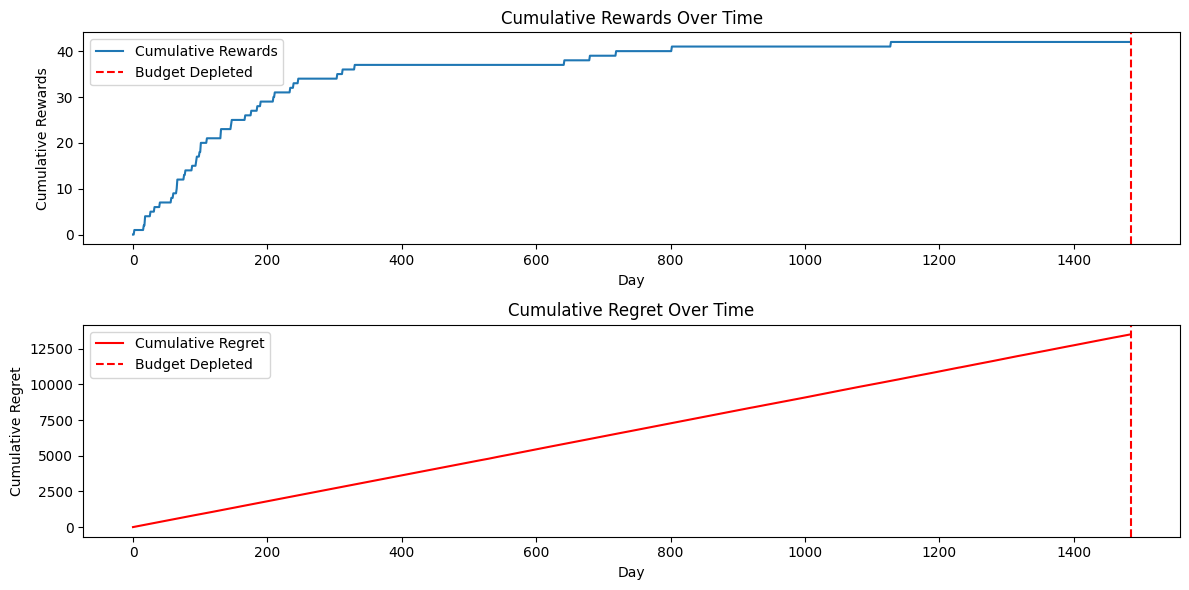

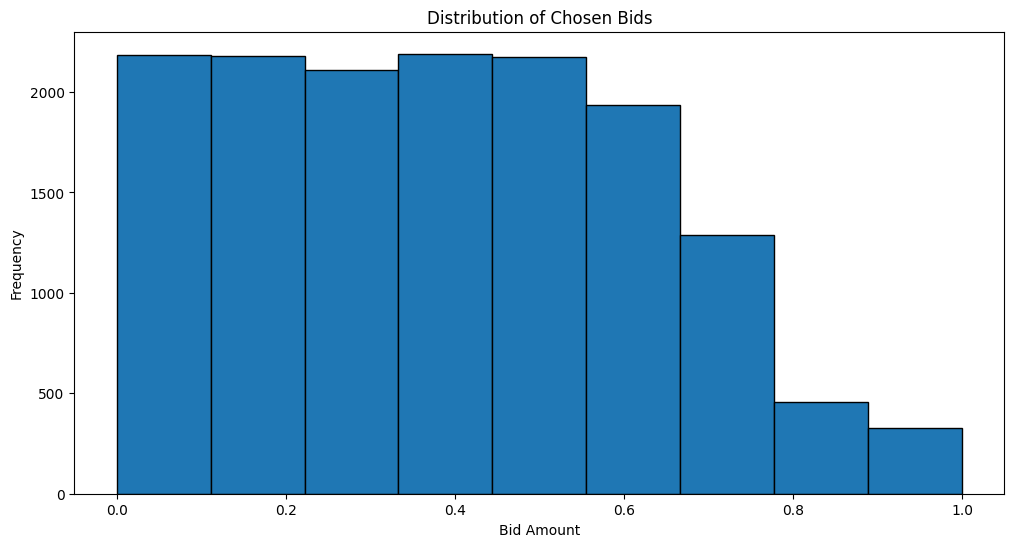

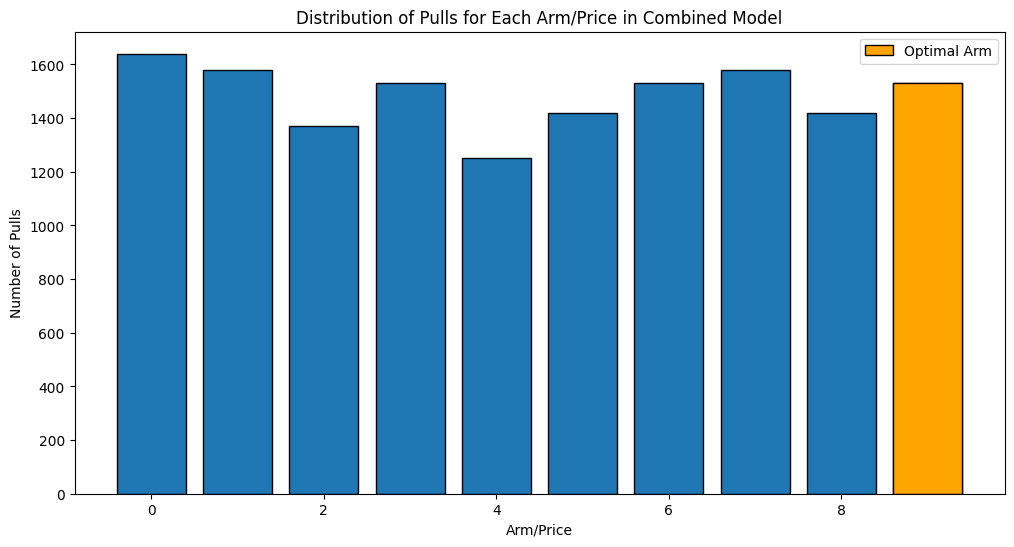

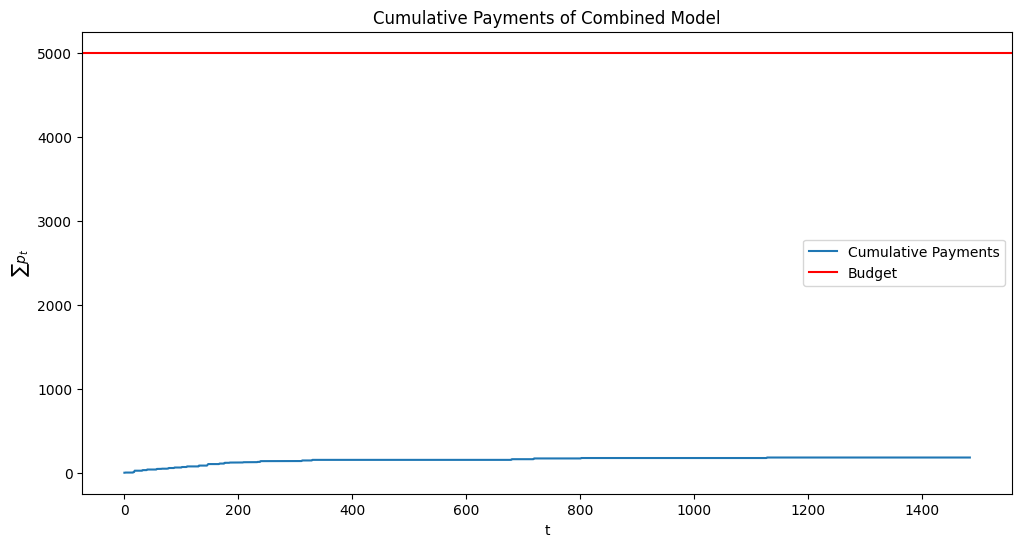

In [ ]:

# Plot the results
plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(range(len(cumulative_rewards)), cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Day')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards Over Time')
plt.legend()
if budget_depleted_day is not None:
    plt.axvline(x=budget_depleted_day, color='r', linestyle='--', label='Budget Depleted')
    plt.legend()


# Plot cumulative regret
plt.subplot(2, 1, 2)
plt.plot(range(len(daily_regrets)), daily_regrets, label='Cumulative Regret', color='red')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
if budget_depleted_day is not None:
    plt.axvline(x=budget_depleted_day, color='r', linestyle='--', label='Budget Depleted')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the distribution of chosen bids
plt.figure(figsize=(12, 6))
plt.hist(chosen_bids, bins=available_bids, edgecolor='black')
plt.xlabel('Bid Amount')
plt.ylabel('Frequency')
plt.title('Distribution of Chosen Bids')
plt.show()

# Plot the distribution of pulls for each arm/price
plt.figure(figsize=(12, 6))
plt.bar(range(NUM_PRICES), arm_pulls, edgecolor='black')
plt.xlabel('Arm/Price')
plt.ylabel('Number of Pulls')
plt.title('Distribution of Pulls for Each Arm/Price in Combined Model')
plt.bar(optimal_arm, arm_pulls[optimal_arm], color='orange', edgecolor='black', label='Optimal Arm')
plt.legend()
plt.show()

# Plot cumulative payments
plt.figure(figsize=(12, 6))
plt.plot(range(len(cumulative_payments)), cumulative_payments, label='Cumulative Payments')
plt.xlabel('t')
plt.ylabel('$\sum p_t$')
plt.title('Cumulative Payments of Combined Model')
plt.axhline(y=initial_budget, color='r', linestyle='-', label='Budget')
plt.legend()
plt.show()

# Seperate Executions


In [4]:
import numpy as np
import matplotlib.pyplot as plt

## Pricing strategy

In [229]:
NUM_DAYS = 5000  # Total number of days
NUM_ROUNDS_PER_DAY = 10  # Number of rounds per day (e.g., auction rounds)
NUM_PRICES = 100  # Number of discrete prices for the pricing strategy
CHANGE_INTERVAL = 1  # Interval for changing the user buying probability distribution

CONVERSION_RATE_MEAN = 0.5  # Mean of the conversion rate (to model user's behavior)
CONVERSION_RATE_STD = 0.1  # Standard deviation of the conversion rate

In [246]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        return np.random.rand(self.num_arms)

    def reset(self):
        if self.t % self.change_interval == 0:
            self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [271]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval, init_mean=0.5, std_dev=0.1):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.std_dev = std_dev
        self.t = 0
        self.means = np.ones(self.num_arms) * init_mean
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        return np.clip(np.random.normal(self.means, self.std_dev), 0, 1)

    def reset(self):
        # Change the means over time to make the environment more adversarial
        if self.t % self.change_interval == 0:
            self.means = np.clip(self.means + np.random.normal(0, 0.01, size=self.num_arms), 0, 1)
            self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [251]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval, function_family="sine"):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.parameters = np.random.rand(self.num_arms) * 2 * np.pi  # Initialize parameters
        self.buying_probabilities = self._generate_buying_probabilities(function_family)

    def _generate_buying_probabilities(self, function_family):
        if function_family == "sine":
            return np.clip(0.5 + 0.5 * np.sin(self.parameters), 0, 1)
    def reset(self, function_family="sine"):
        if self.t % self.change_interval == 0:
            # Adjust the parameters randomly to create changes over time
            self.parameters += np.random.uniform(-0.5, 0.5, self.num_arms)
            self.buying_probabilities = self._generate_buying_probabilities(function_family)

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob


In [252]:
class UCB1:
    def __init__(self, num_arms, T, reward_range=1):
        self.num_arms = num_arms
        self.T = T  # Total number of rounds
        self.reward_range = reward_range
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.t = 0  # Current time step

    def select_arm(self):
        if self.t < self.num_arms:
            return self.t  # Play each arm once initially

        confidence_bounds = self.values + self.reward_range * np.sqrt(
            (2 * np.log(self.T)) / self.counts
        )
        return np.argmax(confidence_bounds)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.t += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value


In [253]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1


In [272]:
# Initialize environment
T = NUM_DAYS * NUM_ROUNDS_PER_DAY
env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)

# Initialize agents
ucb_agent = UCB1(num_arms=NUM_PRICES, T=T)
exp3_agent = EXP3Agent(K=NUM_PRICES, learning_rate=0.1)

# Logging variables
ucb_rewards, exp3_rewards = [], []
ucb_regrets, exp3_regrets = [], []

ucb_total_rewards = exp3_total_rewards = 0
ucb_cumulative_regret = exp3_cumulative_regret = 0

for day in range(NUM_DAYS):
    env.reset()  # Update buying probabilities as per environment dynamics

    ucb_daily_reward = exp3_daily_reward = 0

    for round in range(NUM_ROUNDS_PER_DAY):
        # UCB1 Agent
        ucb_chosen_price = ucb_agent.select_arm()
        ucb_reward = env.round(ucb_chosen_price)
        ucb_agent.update(ucb_chosen_price, ucb_reward)
        ucb_daily_reward += ucb_reward

        # EXP3 Agent
        exp3_chosen_price = exp3_agent.pull_arm()
        exp3_reward = env.round(exp3_chosen_price)
        l_t = 1 - exp3_reward  # Loss is 1 - reward
        exp3_agent.update(l_t)
        exp3_daily_reward += exp3_reward

    ucb_total_rewards += ucb_daily_reward
    exp3_total_rewards += exp3_daily_reward

    # Compute daily regret
    optimal_reward = np.max(env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    ucb_daily_regret = optimal_reward - ucb_daily_reward
    exp3_daily_regret = optimal_reward - exp3_daily_reward
    ucb_cumulative_regret += ucb_daily_regret
    exp3_cumulative_regret += exp3_daily_regret

    # Log rewards and regrets
    ucb_rewards.append(ucb_daily_reward)
    exp3_rewards.append(exp3_daily_reward)
    ucb_regrets.append(ucb_cumulative_regret)
    exp3_regrets.append(exp3_cumulative_regret)

print(f"UCB1 - Total rewards: {ucb_total_rewards}, Cumulative regret: {ucb_cumulative_regret}")
print(f"EXP3 - Total rewards: {exp3_total_rewards}, Cumulative regret: {exp3_cumulative_regret}")


UCB1 - Total rewards: 42007, Cumulative regret: 7553.997983248192
EXP3 - Total rewards: 43778, Cumulative regret: 5782.997983248192


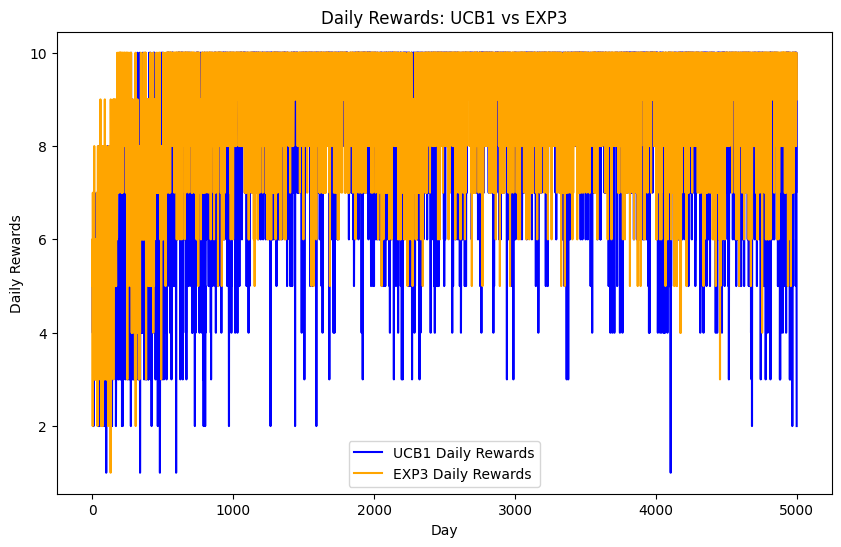

In [273]:
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_DAYS), ucb_rewards, label='UCB1 Daily Rewards', color='blue')
plt.plot(range(NUM_DAYS), exp3_rewards, label='EXP3 Daily Rewards', color='orange')
plt.xlabel('Day')
plt.ylabel('Daily Rewards')
plt.title('Daily Rewards: UCB1 vs EXP3')
plt.legend()
plt.show()


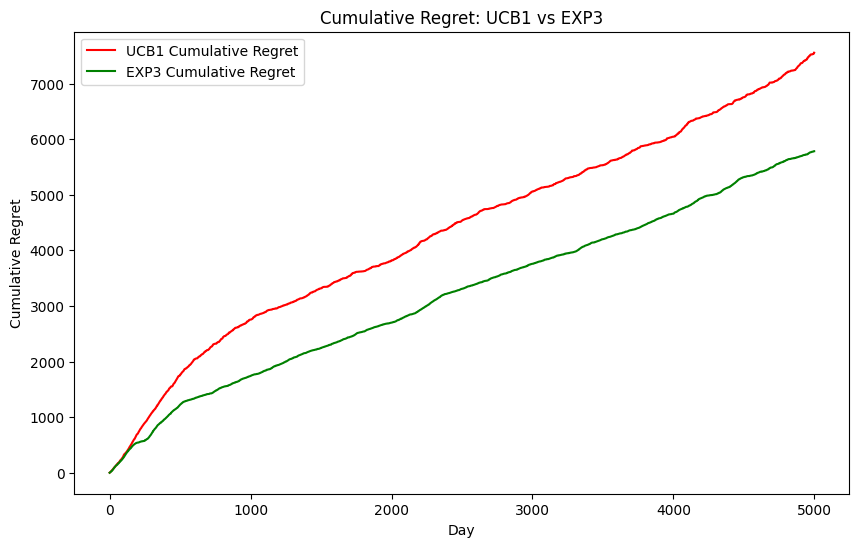

In [274]:
plt.figure(figsize=(10, 6))
plt.plot(range(NUM_DAYS), ucb_regrets, label='UCB1 Cumulative Regret', color='red')
plt.plot(range(NUM_DAYS), exp3_regrets, label='EXP3 Cumulative Regret', color='green')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret: UCB1 vs EXP3')
plt.legend()
plt.show()


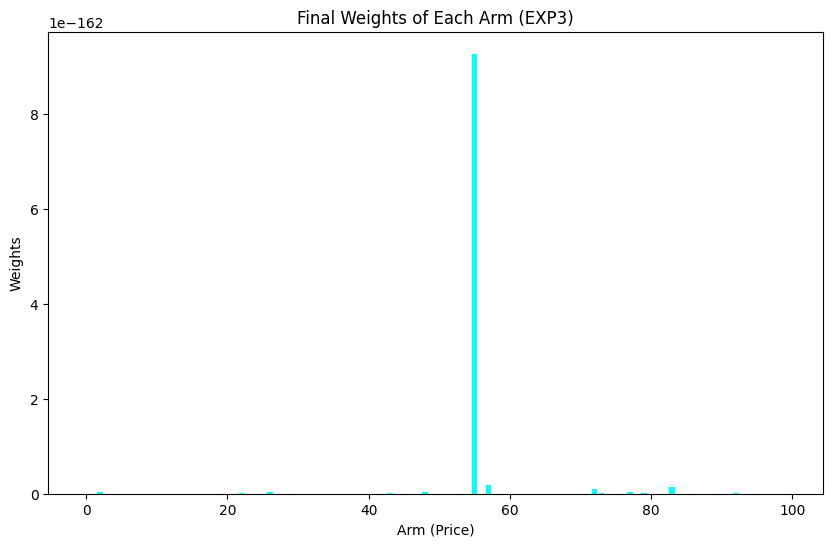

In [275]:
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_PRICES), exp3_agent.weights, color='cyan')
plt.xlabel('Arm (Price)')
plt.ylabel('Weights')
plt.title('Final Weights of Each Arm (EXP3)')
plt.show()


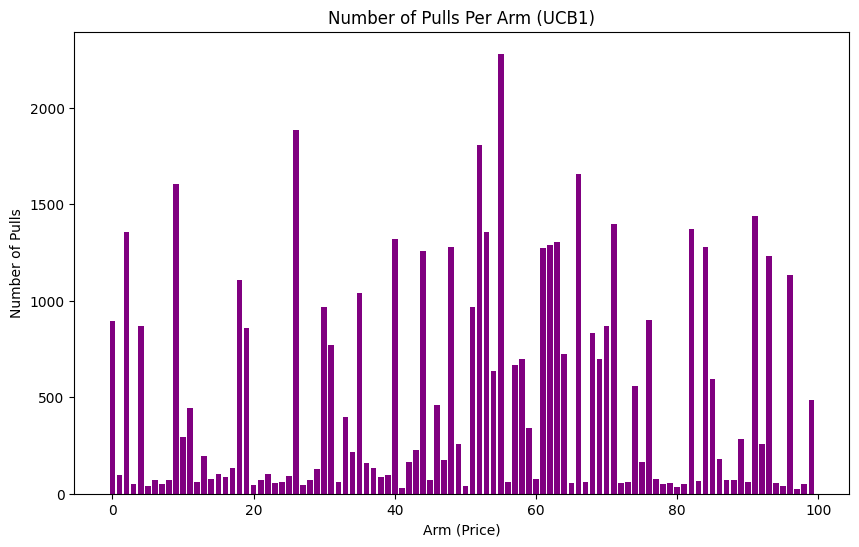

In [276]:
plt.figure(figsize=(10, 6))
plt.bar(range(NUM_PRICES), ucb_agent.counts, color='purple')
plt.xlabel('Arm (Price)')
plt.ylabel('Number of Pulls')
plt.title('Number of Pulls Per Arm (UCB1)')
plt.show()


## Bidding Strategy

In [281]:
# Constants and environment variables
NUM_BIDS = 10  # Number of discrete bid values
NUM_DAYS = 500  # Total number of days for auctions
NUM_AUCTIONS_PER_DAY = 20  # Number of auctions per day
BUDGET = 5000  # Total budget for the agent
VAL_PER_CLICK = 1  # Valuation per click
CHANGE_INTERVAL = 1  # Interval to change adversarial bidding distribution


In [282]:
class AdversarialBiddingEnvironment:
    def __init__(self, num_bidders, num_bids, change_interval):
        self.num_bidders = num_bidders
        self.num_bids = num_bids
        self.change_interval = change_interval
        self.t = 0
        self.bidding_distribution = self._generate_bidding_distribution()

    def _generate_bidding_distribution(self):
        return np.random.rand(self.num_bidders)

    def reset(self):
        if self.t % self.change_interval == 0:
            self.bidding_distribution = self._generate_bidding_distribution()

    def round(self, agent_bid):
        other_bids = np.random.choice(np.linspace(0, 1, self.num_bids), size=self.num_bidders)
        max_bid = np.max(other_bids)
        win = agent_bid > max_bid  # Win if the agent's bid is greater than others
        self.t += 1
        return max_bid, win


In [283]:
class UCB1BiddingAgent:
    def __init__(self, num_bids):
        self.num_bids = num_bids
        self.counts = np.zeros(num_bids)
        self.values = np.zeros(num_bids)
        self.total_counts = 0

    def select_bid(self):
        if self.total_counts < self.num_bids:
            return self.total_counts  # Explore all bids at the beginning

        upper_bounds = self.values + np.sqrt((2 * np.log(self.total_counts)) / self.counts)
        return np.argmax(upper_bounds)

    def update(self, chosen_bid, reward):
        self.counts[chosen_bid] += 1
        self.total_counts += 1
        n = self.counts[chosen_bid]
        value = self.values[chosen_bid]
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_bid] = new_value


In [284]:
class EXP3BiddingAgent:
    def __init__(self, num_bids, learning_rate):
        self.num_bids = num_bids
        self.learning_rate = learning_rate
        self.weights = np.ones(num_bids)
        self.x_t = np.ones(num_bids) / num_bids
        self.a_t = None

    def select_bid(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.num_bids), p=self.x_t)
        return self.a_t

    def update(self, reward):
        loss = -reward  # Convert reward to loss for the EXP3 update
        self.weights[self.a_t] *= np.exp(-self.learning_rate * loss / self.x_t[self.a_t])


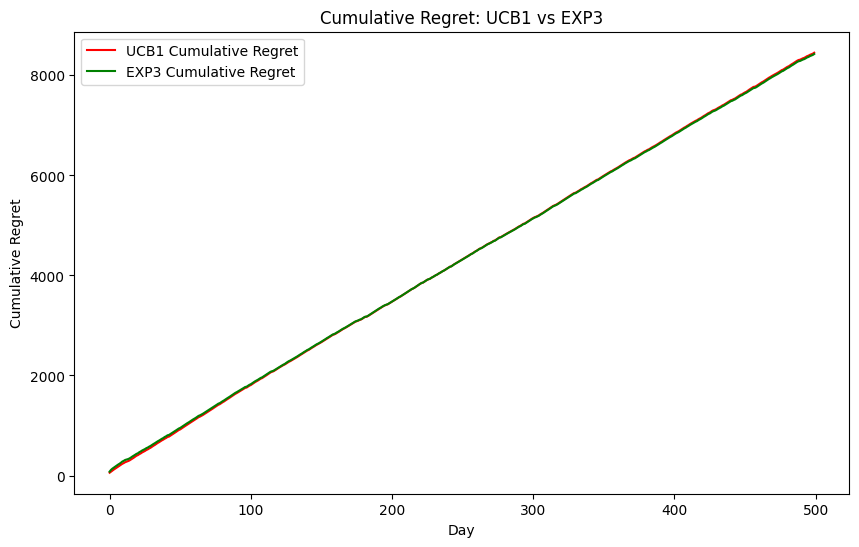

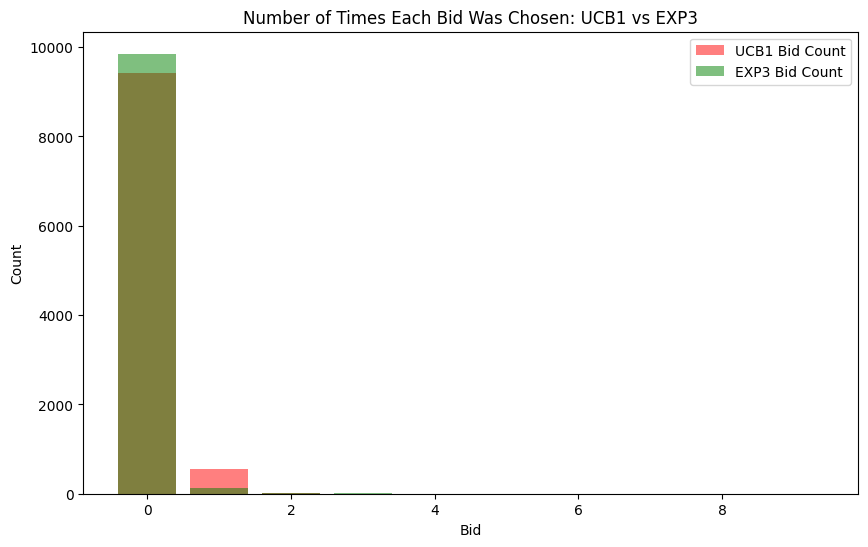

In [288]:
# Initialize bidding environment and agents
env = AdversarialBiddingEnvironment(num_bidders=5, num_bids=NUM_BIDS, change_interval=CHANGE_INTERVAL)
ucb1_agent = UCB1BiddingAgent(num_bids=NUM_BIDS)
exp3_agent = EXP3BiddingAgent(num_bids=NUM_BIDS, learning_rate=0.05)

# Tracking for UCB1
ucb1_total_rewards = 0
ucb1_cumulative_rewards = []
ucb1_cumulative_regret = []
ucb1_optimal_bid_count = np.zeros(NUM_BIDS)

# Tracking for EXP3
exp3_total_rewards = 0
exp3_cumulative_rewards = []
exp3_cumulative_regret = []
exp3_optimal_bid_count = np.zeros(NUM_BIDS)

# Simulation loop
for day in range(NUM_DAYS):
    env.reset()  # Reset the environment every day (adversarial scenario)

    # UCB1 Agent
    ucb1_daily_reward = 0
    for auction_round in range(NUM_AUCTIONS_PER_DAY):
        chosen_bid = ucb1_agent.select_bid()  # UCB1 chooses a bid
        max_bid, win = env.round(chosen_bid)  # Run auction round
        reward = max_bid - chosen_bid if win else 0  # More meaningful reward
        ucb1_agent.update(chosen_bid, reward)  # Update UCB1
        ucb1_daily_reward += reward
        ucb1_optimal_bid_count[chosen_bid] += 1  # Track bid choices

    # Calculate UCB1 Regret
    optimal_bid = np.argmax(env.bidding_distribution)  # Optimal bid based on adversaries
    optimal_reward = env.bidding_distribution[optimal_bid] * NUM_AUCTIONS_PER_DAY
    ucb1_daily_regret = optimal_reward - ucb1_daily_reward
    ucb1_total_rewards += ucb1_daily_reward
    ucb1_cumulative_regret.append(ucb1_daily_regret + (ucb1_cumulative_regret[-1] if ucb1_cumulative_regret else 0))
    ucb1_cumulative_rewards.append(ucb1_total_rewards)

    # EXP3 Agent
    exp3_daily_reward = 0
    for auction_round in range(NUM_AUCTIONS_PER_DAY):
        chosen_bid = exp3_agent.select_bid()  # EXP3 chooses a bid
        max_bid, win = env.round(chosen_bid)  # Run auction round
        reward = max_bid - chosen_bid if win else 0  # More meaningful reward
        exp3_agent.update(reward)  # Update EXP3
        exp3_daily_reward += reward
        exp3_optimal_bid_count[chosen_bid] += 1  # Track bid choices

    # Calculate EXP3 Regret
    exp3_daily_regret = optimal_reward - exp3_daily_reward
    exp3_total_rewards += exp3_daily_reward
    exp3_cumulative_regret.append(exp3_daily_regret + (exp3_cumulative_regret[-1] if exp3_cumulative_regret else 0))
    exp3_cumulative_rewards.append(exp3_total_rewards)

# Plot results
plt.figure(figsize=(10,6))
plt.plot(ucb1_cumulative_regret, label="UCB1 Cumulative Regret", color='red')
plt.plot(exp3_cumulative_regret, label="EXP3 Cumulative Regret", color='green')
plt.title("Cumulative Regret: UCB1 vs EXP3")
plt.xlabel("Day")
plt.ylabel("Cumulative Regret")
plt.legend()
plt.show()

# Plot the number of times each bid was chosen
plt.figure(figsize=(10,6))
plt.bar(np.arange(NUM_BIDS), ucb1_optimal_bid_count, color='red', alpha=0.5, label="UCB1 Bid Count")
plt.bar(np.arange(NUM_BIDS), exp3_optimal_bid_count, color='green', alpha=0.5, label="EXP3 Bid Count")
plt.title("Number of Times Each Bid Was Chosen: UCB1 vs EXP3")
plt.xlabel("Bid")
plt.ylabel("Count")
plt.legend()
plt.show()